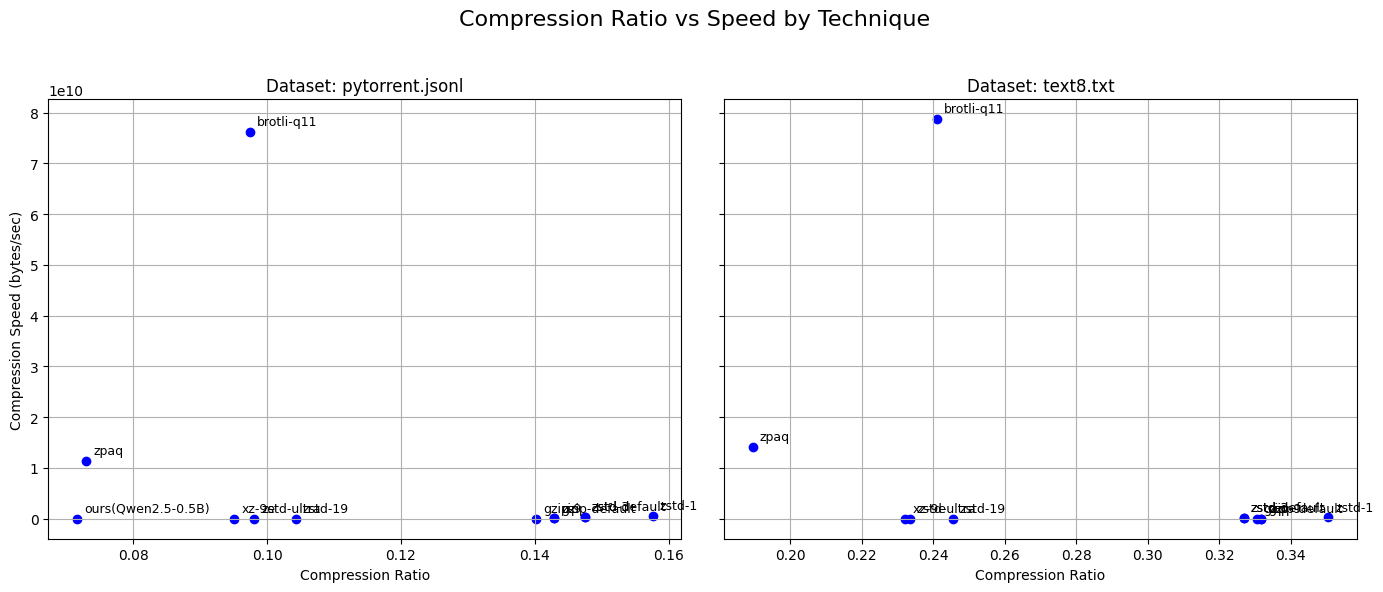

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv('competitors.csv')

# Compute metrics
df['compression_ratio'] = df['Compressed Size'] / df['Dataset Size']
df['compression_speed'] = df['Dataset Size'] / df['Compression Duration']

# Get unique datasets
datasets = df['Dataset'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(datasets), figsize=(14, 6), sharey=True)

# Ensure axes is iterable
if len(datasets) == 1:
    axes = [axes]

# Plot per dataset
for ax, dataset in zip(axes, datasets):
    subset = df[df['Dataset'] == dataset]
    ax.scatter(subset['compression_ratio'], subset['compression_speed'], color='blue')

    # Add annotations
    for _, row in subset.iterrows():
        ax.annotate(row['Technique'],
                    (row['compression_ratio'], row['compression_speed']),
                    textcoords="offset points",
                    xytext=(5,5),
                    ha='left',
                    fontsize=9)

    ax.set_title(f'Dataset: {dataset.split("/")[-1]}')
    ax.set_xlabel('Compression Ratio')
    ax.grid(True)

axes[0].set_ylabel('Compression Speed (bytes/sec)')
fig.suptitle('Compression Ratio vs Speed by Technique', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

25000.0


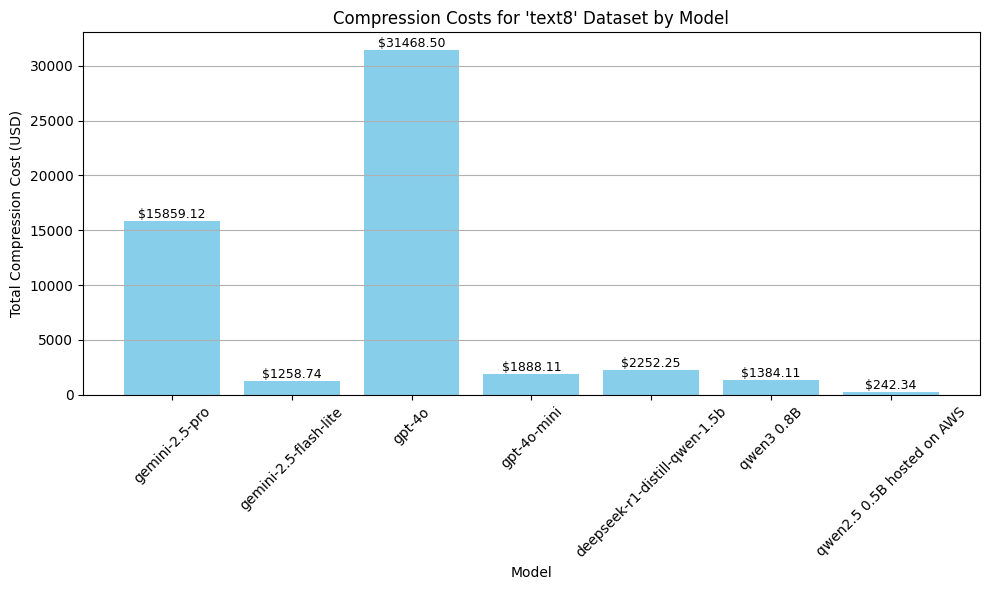

In [3]:
import matplotlib.pyplot as plt

# Configuration
output_token_per_chunk = 999
input_tokens_per_chunk = 499500
total_tokens = 25_000_000  # size of text8 dataset, just approximate

qwen25_compression_seconds_per_chunk = 18.7516143293 # approx.
aws_instance_price_per_hour = 1.861 # g6e.xlarge

# Cost per 1 million tokens (USD)
model_costs = {
    "gemini-2.5-pro": {"input": 1.25, "output": 10.0},
    "gemini-2.5-flash-lite": {"input": 0.1, "output": 0.4},
    "gpt-4o": {"input": 2.5, "output": 10.0},
    "gpt-4o-mini": {"input": 0.15, "output": 0.60},
    "deepseek-r1-distill-qwen-1.5b": {"input": 0.18, "output": 0.18},
    "qwen3 0.8B": {"input": 0.11, "output": 0.42},
}

# Compute number of chunks
num_chunks = total_tokens / 1000
print(num_chunks)

# Calculate total cost per model
costs = {}
for model, rates in model_costs.items():
    total_cost = (((input_tokens_per_chunk * num_chunks) / 1000000) * rates["input"]) + (((output_token_per_chunk * num_chunks) / 1000000) * rates["output"])
    costs[model] = total_cost

costs['qwen2.5 0.5B hosted on AWS'] = (num_chunks * qwen25_compression_seconds_per_chunk) / 60 / 60 * aws_instance_price_per_hour

# Plotting
models = list(costs.keys())
values = list(costs.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, values, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Total Compression Cost (USD)")
plt.title("Compression Costs for 'text8' Dataset by Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.05,
        f"${yval:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2742031360.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Technique', y='Compression Factor', data=text8_df, ax=axes[0], palette=text8_colors)
/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2742031360.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(text8_df['Technique'], rotation=45, ha='right', fontsize=7)
/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2742031360.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Technique', y='Compression Factor', data=pytorrent_d

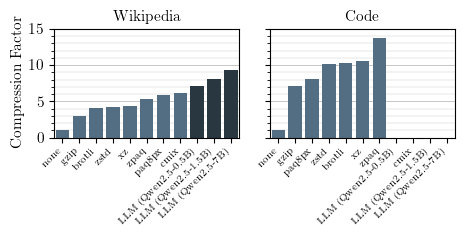

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Which techniques to include in the plot from the CSV file. Also rename them for better readability.
technique_includelist = {
    'none': 'none',
    'gzip-9': 'gzip',
    'zstd-ultra': 'zstd',
    'xz-9e': 'xz',
    'brotli-q11': 'brotli',
    'zpaq': 'zpaq',
    'paq8px -12': 'paq8px',
    'cmix': 'cmix',
    'qwen2.5 0.5B': 'LLM (Qwen2.5-0.5B)',
    'qwen2.5 1.5B': 'LLM (Qwen2.5-1.5B)',
    'qwen2.5 7B': 'LLM (Qwen2.5-7B)',
}

df = pd.read_csv('competitors.csv')
df = df[df['Technique'].isin(technique_includelist.keys())]
df['Technique'] = df['Technique'].map(technique_includelist)
df['Compression Factor'] = df['Dataset Size'] / df['Compressed Size']
df = df.sort_values(by='Compression Factor', ascending=True)
text8_df = df[df['Dataset'] == 'data/text8.txt']
pytorrent_df = df[df['Dataset'] == 'data/pytorrent.jsonl']

matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif', 'axes.titlesize': 'medium', 'figure.titlesize': 'medium', 'text.usetex': True, 'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}\\usepackage{siunitx}[=v2]', 'pgf.rcfonts': False, 'pgf.texsystem': 'pdflatex'})
fig, axes = plt.subplots(1, 2, figsize=(4.9, 2.5), sharey=True)

def get_bar_colors(techniques):
    return ["#253745" if str(t).startswith('LLM') else '#4B6F8A' for t in techniques]

# Compression factor for text8
text8_colors = get_bar_colors(text8_df['Technique'])
sns.barplot(x='Technique', y='Compression Factor', data=text8_df, ax=axes[0], palette=text8_colors)
axes[0].set_title('Wikipedia')
axes[0].set_xticklabels(text8_df['Technique'], rotation=45, ha='right', fontsize=7)
axes[0].grid(zorder=0)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('')

# Compression factor for pytorrent
pytorrent_colors = get_bar_colors(pytorrent_df['Technique'])
sns.barplot(x='Technique', y='Compression Factor', data=pytorrent_df, ax=axes[1], palette=pytorrent_colors)
axes[1].set_title('Code')
axes[1].set_xticklabels(pytorrent_df['Technique'], rotation=45, ha='right', fontsize=7)
axes[1].grid(zorder=0)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('')



# Add more horizontal lines on the y-axis for both subplots
for ax in axes:
    # Make sure the y-axis ends with a major tick
    y_max = ax.get_ylim()[1]
    major_locator = ax.yaxis.get_major_locator()
    major_ticks = major_locator()
    next_major = major_ticks[major_ticks > y_max][0] if any(major_ticks > y_max) else y_max
    ax.set_ylim(ax.get_ylim()[0], next_major)

    # Show grid lines
    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
    ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=0.2, zorder=0)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig("compression_factors.pdf", dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()

/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2423913812.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='compressor', y='compression factor', data=text8_df, ax=ax, palette=text8_colors)
/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2423913812.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(text8_df['compressor'], rotation=45, ha='right', fontsize=7)
/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/2423913812.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='compressor', y='compression factor', data=pytorrent_df, ax=a

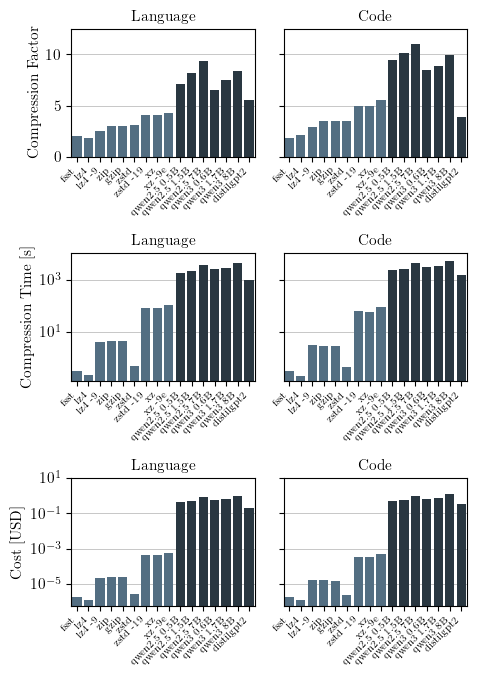

In [176]:
from matplotlib.ticker import LogLocator
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif', 'axes.titlesize': 'medium', 'figure.titlesize': 'medium', 'text.usetex': True, 'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}\\usepackage{siunitx}[=v2]', 'pgf.rcfonts': False, 'pgf.texsystem': 'pdflatex'})

# Read an prepare data
df_text8_cpu = pd.read_csv('../text8_c8g.medium_0.019USD.csv')
df_text8_cpu['cost'] = 0.019 / 60 / 60 * df_text8_cpu['time']
df_text8_cpu['orig size'] = 100000000
df_text8_cpu['dataset'] = 'text8'
df_text8_llm = pd.read_csv('../text8_g6e.xlarge_0.804USD.csv')
df_text8_llm['cost'] = 0.804 / 60 / 60 * df_text8_llm['time']
df_text8_llm['orig size'] = 100000000
df_text8_llm['dataset'] = 'text8'
df_pytorrent_cpu = pd.read_csv('../combined_c8g.medium_0.019USD.csv')
df_pytorrent_cpu['cost'] = 0.019 / 60 / 60 * df_pytorrent_cpu['time']
df_pytorrent_cpu['orig size'] = 100000000
df_pytorrent_cpu['dataset'] = 'pytorrent'
df_pytorrent_gpu = pd.read_csv('../combined_g6e.xlarge_0.804USD.csv')
df_pytorrent_gpu['cost'] = 0.804 / 60 / 60 * df_pytorrent_gpu['time']
df_pytorrent_gpu['orig size'] = 100000000
df_pytorrent_gpu['dataset'] = 'pytorrent'

df = pd.concat([df_text8_cpu, df_text8_llm, df_pytorrent_cpu, df_pytorrent_gpu])
df['compression factor'] = df['orig size'] / df['size']
df = df[~df['compressor'].isin(['uncompressed'])]
#df = df.sort_values(by='compression factor', ascending=True)

text8_df = df[df['dataset'] == 'text8']
pytorrent_df = df[df['dataset'] == 'pytorrent']

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(4.9, 2.3 * 3), sharey='row')

def get_bar_colors(techniques):
    return ["#253745" if str(t).startswith('qwen') or str(t).startswith('distil') else '#4B6F8A' for t in techniques]

# Compression factor for text8
ax = axes[0][0]
text8_colors = get_bar_colors(text8_df['compressor'])
sns.barplot(x='compressor', y='compression factor', data=text8_df, ax=ax, palette=text8_colors)
ax.set_title('Language')
ax.set_xticklabels(text8_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')
ax.set_ylabel('Compression Factor')

# Compression factor for text8
ax = axes[0][1]
text8_colors = get_bar_colors(pytorrent_df['compressor'])
sns.barplot(x='compressor', y='compression factor', data=pytorrent_df, ax=ax, palette=text8_colors)
ax.set_title('Code')
ax.set_xticklabels(pytorrent_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')

# Compression time for text8
ax = axes[1][0]
text8_colors = get_bar_colors(text8_df['compressor'])
sns.barplot(x='compressor', y='time', data=text8_df, ax=ax, palette=text8_colors)
ax.set_title('Language')
ax.set_xticklabels(text8_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')
ax.set_ylabel('Compression Time [s]')
ax.set_yscale('log')

# Compression time for pytorrent
ax = axes[1][1]
text8_colors = get_bar_colors(pytorrent_df['compressor'])
sns.barplot(x='compressor', y='time', data=pytorrent_df, ax=ax, palette=text8_colors)
ax.set_title('Code')
ax.set_xticklabels(pytorrent_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')

# Compression cost for text8
ax = axes[2][0]
text8_colors = get_bar_colors(text8_df['compressor'])
sns.barplot(x='compressor', y='cost', data=text8_df, ax=ax, palette=text8_colors)
ax.set_title('Language')
ax.set_xticklabels(text8_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')
ax.set_ylabel('Cost [USD]')
ax.set_yscale('log')

# Compression cost for pytorrent
ax = axes[2][1]
pytorrent_colors = get_bar_colors(pytorrent_df['compressor'])
sns.barplot(x='compressor', y='cost', data=pytorrent_df, ax=ax, palette=pytorrent_colors)
ax.set_title('Code')
ax.set_xticklabels(pytorrent_df['compressor'], rotation=45, ha='right', fontsize=7)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel('')

for row in axes:
    for ax in row:
        
        ax.xaxis.grid(False)
        # Make sure the y-axis ends with a major tick
        y_max = ax.get_ylim()[1]
        major_locator = ax.yaxis.get_major_locator()
        major_ticks = major_locator()
        next_major = major_ticks[major_ticks >= y_max][0] if any(major_ticks >= y_max) else y_max
        ax.set_ylim(ax.get_ylim()[0], next_major)



        

plt.tight_layout()
plt.savefig("compression_overview.pdf", dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()